# Банки - Анализ оттока клиентов

## Задача:
### Проанализируйте клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.

- Проведите исследовательский анализ данных,
- Выделите портреты клиентов, которые склонны уходить из банка,
- Сформулируйте и проверьте статистические гипотезы.
    
    *Проверьте гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.*
    
    *Сформулируйте и проверьте статистическую гипотезу относительно представленных данных*

### Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

1. [Начало](#start)
2. [Исследовательский анализ данных (EDA)](#EDA)
3. [Проверка статистических гипотез](#hypothesis)
4. [Общий вывод и рекомендации](#recomendations)

# 1 Шаг: Откроем файл с данными и изучим общую информацию

In [1]:
# Импортируем все необходмые библиотеки

from collections import Counter 
import datetime as dt

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np 
import math as mth
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats as st
import scipy.stats as stats
import re
from io import BytesIO
import requests

from plotly import graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode()

plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML('<style>.container{width:80% !important;}</style>'))
from IPython.display import display, Markdown
pd.set_option('display.float.format', lambda x: '%.3f' %x)

import warnings
warnings.filterwarnings('ignore')

!pip install --upgrade seaborn


Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.2)


<a id="start"></a> 

In [2]:
#Загрузка данных
df = pd.read_csv('/datasets/bank_dataset.csv')


def print_columns_info_missing_values_and_duplicates(df):
    display(df)
    print('The dataframe includes', df.loc[0 , :].count(), 'columns.',
         'They are called', df.columns.to_list())
    print(' ')
    print('----------------------------------\
-----------------------------------------')
    print(' ')
    print(df.info())
    print(' ')
    print('----------------------------------\
-----------------------------------------')
    print(' ')
    for column in df.columns:
        print('In column', column, 'there are', 
             df[column].isna().sum(), 'missing values')
    print(' ')
    print('----------------------------------\
-----------------------------------------')
    print(' ')
    print('There are', df.duplicated().sum(), 'duplicates')
    
print_columns_info_missing_values_and_duplicates(df)

userid  score            City Gender  Age  Objects    Balance  \
0     15677338  619    Ярославль       Ж      42   2       nan          
1     15690047  608    Рыбинск         Ж      41   1       83807.860    
2     15662040  502    Ярославль       Ж      42   8       159660.800   
3     15744090  699    Ярославль       Ж      39   1       nan          
4     15780624  850    Рыбинск         Ж      43   2       125510.820   
...        ...  ...        ...        ..      ..  ..              ...   
9995  15648965  771    Ярославль       М      39   5       nan          
9996  15612628  516    Ярославль       М      35   10      57369.610    
9997  15627268  709    Ярославль       Ж      36   7       nan          
9998  15725091  772    Ростов Великий  М      42   3       75075.310    
9999  15671055  792    Ярославль       Ж      28   4       130142.790   

      Products  CreditCard  Loyalty  estimated_salary  Churn  
0     1         1           1       101348.880         1      
1     1         0           1       112542.580         0      
2     3         1           0       113931.570         1      
3     2         0           0       93826.630          0      
4     1         1           1       79084.100          0      
...  ..        ..          ..             ...         ..      
9995  2         1           0       96270.640          0      
9996  1         1           1       101699.770         0      
9997  1         0           1       42085.580          1      
9998  2         1           0       92888.520          1      
9999  1         1           0       38190.780          0      

[10000 rows x 12 columns]

The dataframe includes 11 columns. They are called ['userid', 'score', 'City', 'Gender', 'Age', 'Objects', 'Balance', 'Products', 'CreditCard', 'Loyalty', 'estimated_salary', 'Churn']
 
---------------------------------------------------------------------------
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
City                10000 non-null object
Gender              10000 non-null object
Age                 10000 non-null int64
Objects             10000 non-null int64
Balance             6383 non-null float64
Products            10000 non-null int64
CreditCard          10000 non-null int64
Loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
Churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None
 
------------------------------------------------------------

<div class='alert alert-warning'>
Не хватает предположений относительно пропусков в поле баланса.

На самом деле если посмотреть на пропуски в разрезе городов, то можно заметить что для одного городов пропуски отсутствуют в принципе. Можно предположить о том что клиентов в данном городе привлекли за счет зарплатного проекта заключив договор с какой-то организацией.

# 2 Шаг: Подготовим данные

В целом, в с данными всё впорядке.\
Имеются много пропусков в столбце Balance, но мы не будем эти пропуски ни на что не менять, так как при анлизе это сильно исказит наши данные.\
Также можно для удобноства привести все столбцы к нижнему регистру.

In [3]:
# Приведём название столбцов к ниэнему регистру
df.columns = df.columns.str.lower()

<div class='alert alert-success'>
Здорово что владеешь встроенными методами работы со строками.

<a id="EDA"></a> 

# 3 Шаг: Проведём исследовательский анализ данных

In [4]:
df.head()

userid  score       city gender  age  objects    balance  products  \
0  15677338  619    Ярославль  Ж      42   2       nan         1          
1  15690047  608    Рыбинск    Ж      41   1       83807.860   1          
2  15662040  502    Ярославль  Ж      42   8       159660.800  3          
3  15744090  699    Ярославль  Ж      39   1       nan         2          
4  15780624  850    Рыбинск    Ж      43   2       125510.820  1          

   creditcard  loyalty  estimated_salary  churn  
0  1           1       101348.880         1      
1  0           1       112542.580         0      
2  1           0       113931.570         1      
3  0           0       93826.630          0      
4  1           1       79084.100          0

In [5]:
df.groupby('churn').mean()

userid   score    age  objects    balance  products  creditcard  \
churn                                                                         
0     15733903.882 651.853 37.408 5.033    119535.864 1.544     0.707         
1     15732787.965 645.351 44.838 4.933    120746.971 1.475     0.699         

       loyalty  estimated_salary  
churn                             
0     0.555    99738.392          
1     0.361    101465.678

Заметим, что люди, которые уходят в отток в среднем старше на 7 лет

Выделим отдельные датафреймы с оттоком клиентов и тех, кто остался

In [6]:
# Отдельный датафейм для клиентов, которые отказались от услуг
churn = df[(df['churn'] == 1) & (df['balance'] != 'nan')]

In [7]:
# Отдельный датафейм для клиентов, которые не отказались от услуг
no_churn = df[(df['churn'] == 0) & (df['balance'] != 'nan')]

In [8]:
list_columns = ['userid', 'score', 'age', 'objects', 'balance', 'products', 'creditcard', 'loyalty',
               'estimated_salary', 'churn']

In [9]:
def draw(df1, df2):
    for column in list_columns:
        df1[column].plot(kind = 'hist', alpha = 0.5, label = 'Отток')
        df2[column].plot(kind = 'hist', alpha = 0.5, label = 'Клиент')
        plt.title(column)
        plt.ylabel('Количество человек')
        plt.legend()
        plt.show()

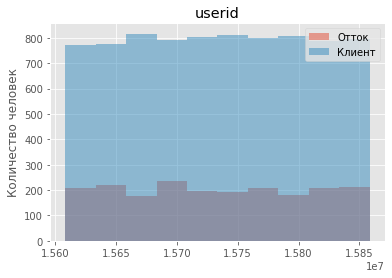

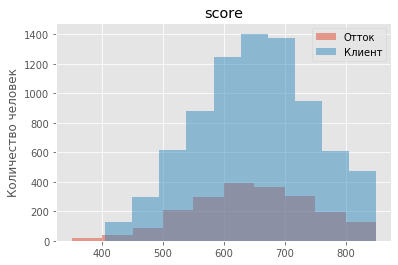

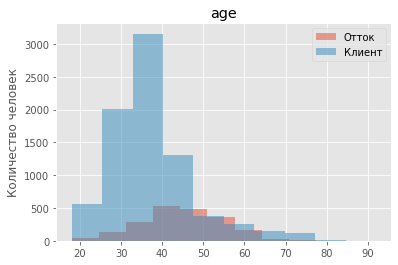

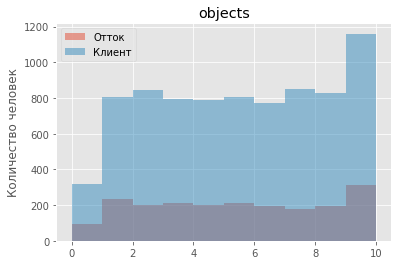

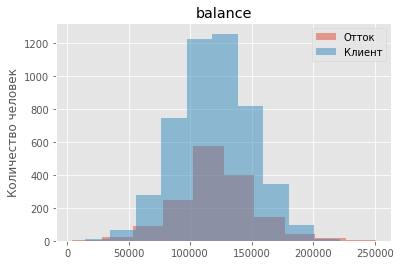

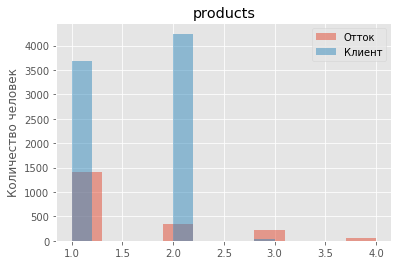

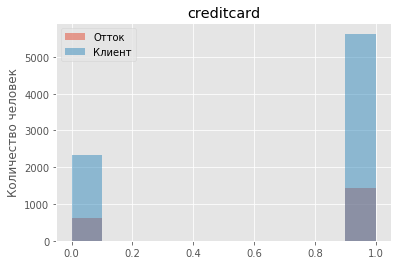

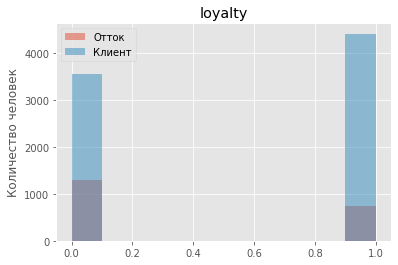

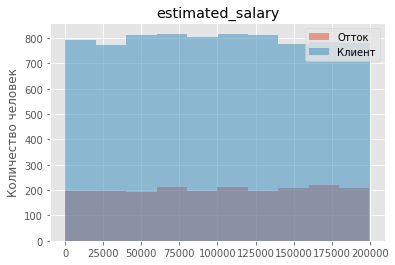

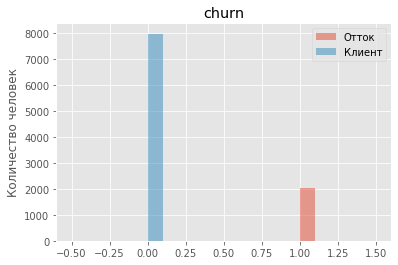

In [10]:
draw(churn, no_churn)

Исходя из графиков, можно сделать следующий вывод:\
Клиенты, которые уходят в отток зачастую пользуются только одним продуктом.\


In [11]:
cm = df.corr()

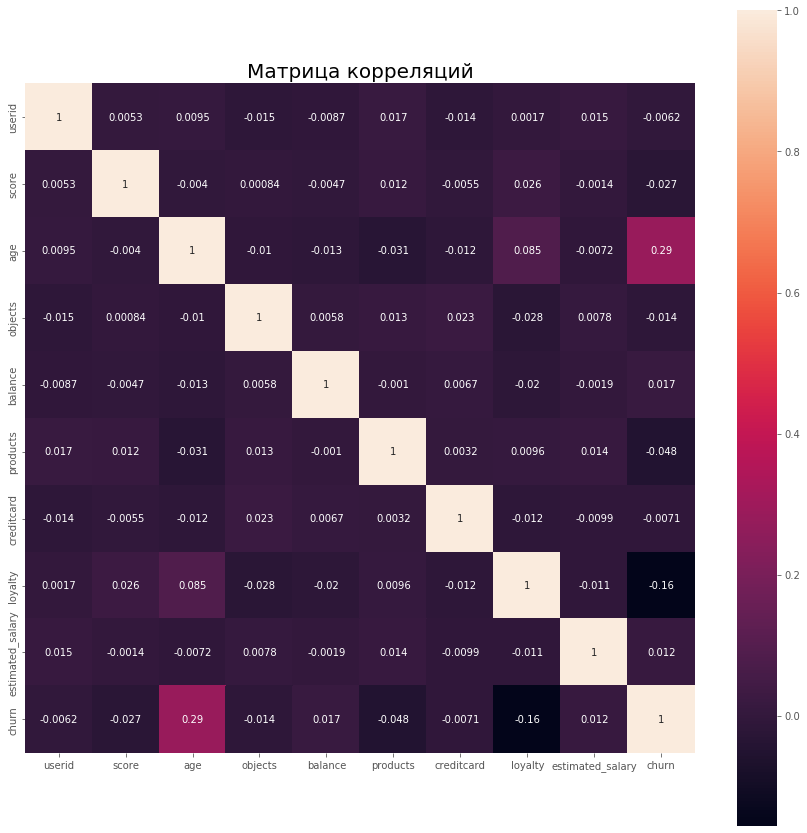

In [12]:
# Посмотрим корреляцию признаков
plt.figure(figsize=(15,15))
sns.heatmap(cm, square = True, annot = True)
plt.title('Матрица корреляций', fontsize=20)
plt.show()

<div class='alert alert-success'>
Круто что владеешь такой мощной техникой визуализации как тепловая карта. На ней прекрасно видно что особых корреляций между признаками нет. В такой ситуапции стоит подумать о том, что возможно признаки имеют нелинейные связи. Для выявления таких нелинейных взаимосвязей я рекомендую дополнительно посмотреть на корреляцию Спирмена, а в идеале познакомиться с очень продвинутым коэффициентом корреляции Phik. С его помощью можно получать адекватные значения корреляции для данных любой природы. https://phik.readthedocs.io/en/latest/introduction.html

Не хватает корреляций по городам. Не совсем очевидно в чем пользо от расчета корреляции user-id с остальными признаками.

In [13]:
df.groupby('city').agg({'userid': 'nunique'}).sort_values(by='userid', ascending=False)

userid
city                  
Ярославль       5014  
Ростов Великий  2509  
Рыбинск         2477

Количество пользователей в разных городах варьируется.\
Ярославль занимает 1 место по количеству клиентов.

Разделим данные по 3-м разным городам и посмотрим на признаки в этих городах.

In [14]:
# Выделим датафрейм для города Рыбинск
df_ribinsk = df[df['city'] == "Рыбинск"]

In [15]:
# Выделим датафрейм для города Ярославль
df_yaroslavl = df[df['city'] == "Ярославль"]

In [16]:
# Выделим датафрейм для города Ростов Великий
df_rostov = df[df['city'] == "Ростов Великий"]

Проанализируем признаки по трём разным городам.\
Начнём с Рыбинска 

In [17]:
df_ribinsk.groupby('churn').mean()

userid   score    age  objects    balance  products  creditcard  \
churn                                                                         
0     15735502.309 652.104 37.839 5.108    119820.562 1.545     0.699         
1     15730416.942 647.484 44.148 4.656    119792.058 1.513     0.673         

       loyalty  estimated_salary  
churn                             
0     0.567    98602.370          
1     0.341    103629.555

Посмотрим на распределение признаков по оттоку в городе Рыбинск:

In [18]:
# Создам словарь перевода признаков на русский язык для красивого выведения заголовков 
translate_list = {'userid': 'Идентификатор пользователя',
                  'score': 'Баллы кредит. скор.',
                  'city': 'Город',
                  'gender': 'Пол',
                  'age': 'Возраст',
                  'objects': 'Количество объектов',
                  'balance': 'Баланс на счёте',
                  'products': 'Количество продуктов',
                  'creditcard': 'Есть ли кредитная карта',
                  'loyalty': 'Активный клиент',
                  'estimated_salary': 'Заработная плата клиента',
                  'churn': 'Отток клиента'}

# А также необходим словарь для единиц измерений
unit = {'score': 'Количество баллов',
        'age': 'Возраст(лет)',
        'balance': 'Баланс на карте (в рублях)',
        'estimated_salary': 'заработная плата (в рублях)',
        'objects': 'Количество объектов (шт)',
        'products': 'Количество продуктов (шт)',
        'creditcard': 'Наличие кредитной карты (1-да, 0-нет)',
        'loyalty': 'Активность клиента (1-да, 0-нет)'}

In [19]:
# Выделим список столбцов для визуализации histplot
columns1 = ['score', 'age', 'balance', 'estimated_salary']

In [20]:
# Выделим список столбцов для визуализации countplot
columns2 = ['objects', 'products', 'creditcard', 'loyalty']

In [21]:
# Выделим нумерацию для построения матрицы сабплотов
location = [221, 222, 223, 224]

In [22]:
def draws1(df1):                                    #Функция, строящая гистограммы по признакам
    plt.figure(figsize=(14,11))
    for col, loc in zip(columns1, location):
        plt.subplot(loc)
        sns.histplot(data=df1, x=col, hue='churn', palette='colorblind', legend=False)
        plt.title(f"Распределение '{translate_list[col]}' по оттоку", fontsize=14)
        plt.ylabel('Количество клиентов', fontsize=10, labelpad=12)
        plt.xlabel(unit[col], fontsize=10)
        plt.legend(('Ушёл в отток', 'Не ушёл'))
    

In [23]:
def draws2(df2):                                   #Функция, строящая гистограммы по признакам
    plt.figure(figsize=(14,11))
    for col, loc in zip(columns2, location):
        plt.subplot(loc)
        sns.countplot(data=df2, x=col, hue='churn', palette='colorblind')
        plt.title(f"Распределение '{translate_list[col]}' по оттоку", fontsize=14)
        plt.ylabel('Количество клиентов', fontsize=10, labelpad=12)
        plt.xlabel(unit[col], fontsize=10)
        plt.legend(('Остался', 'Ушёл в отток'))

<div class='alert alert-success'>
Очень похвально что заранее определяешь функции для отрисовки, это сокращает количество кода и повышает его читаемость.

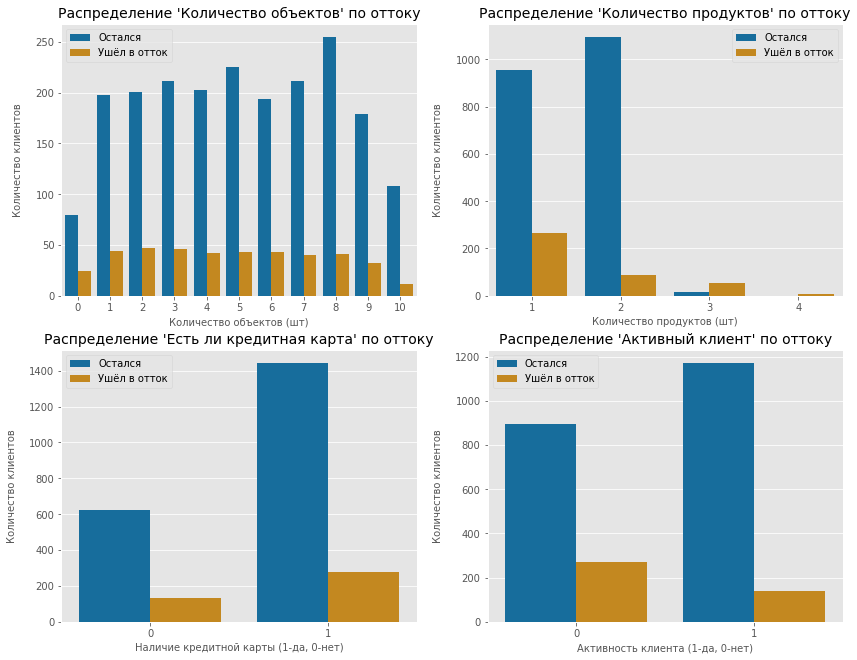

In [24]:
draws2(df_ribinsk)

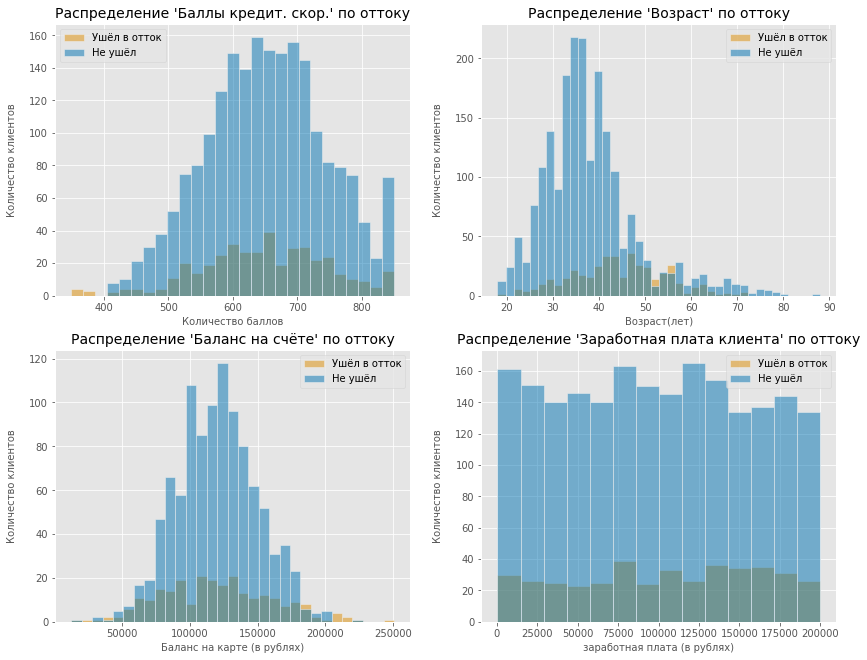

In [25]:
draws1(df_ribinsk)

In [26]:
df_ribinsk['churn'].value_counts().reset_index().rename(columns={'index': 'churn', 'churn': 'number'})

churn  number
0  0      2064  
1  1      413

In [27]:
df_ribinsk.isna().sum()

userid              0   
score               0   
city                0   
gender              0   
age                 0   
objects             0   
balance             1199
products            0   
creditcard          0   
loyalty             0   
estimated_salary    0   
churn               0   
dtype: int64

Подытог по городу Рыбинск:
1) Значительную часть пользователей мы теряем в признаке "products". Мы можем заметить, что клиент имеющий 2 продукта менее склонен уходить, чем какой-либо другой пользователь
2) Также, если клиент не проявляет активность, то скорее всего он уйдёт в отток.\
3) Имеется корреляция между наличием кредитной карты и уходом в отток.\
4) Клиент, имеющий < 400 скоринговых баллов, вероято, скоро покинет банк.\
5) Чем старше пользователь, тем выше шанс его потерять, как клиента

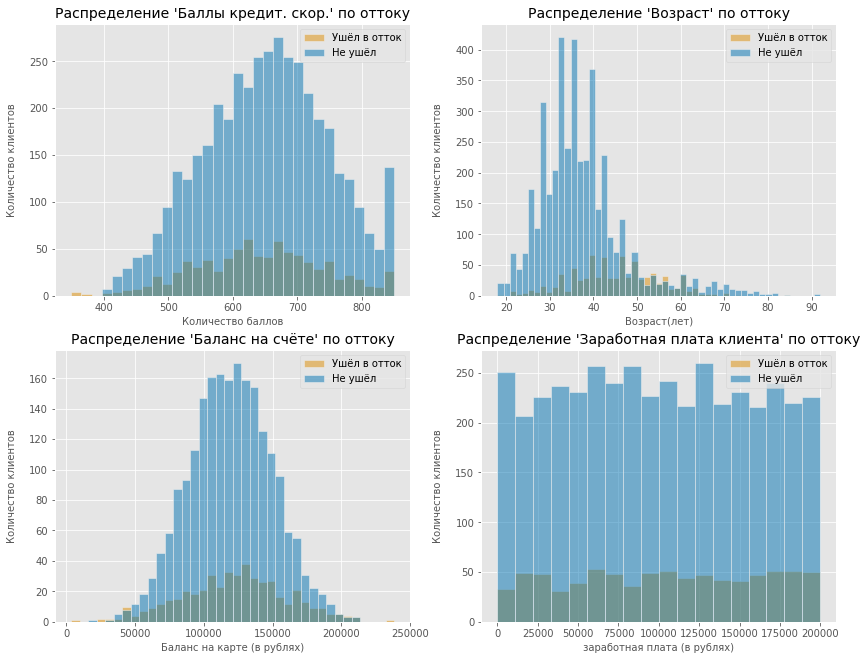

In [28]:
draws1(df_yaroslavl)

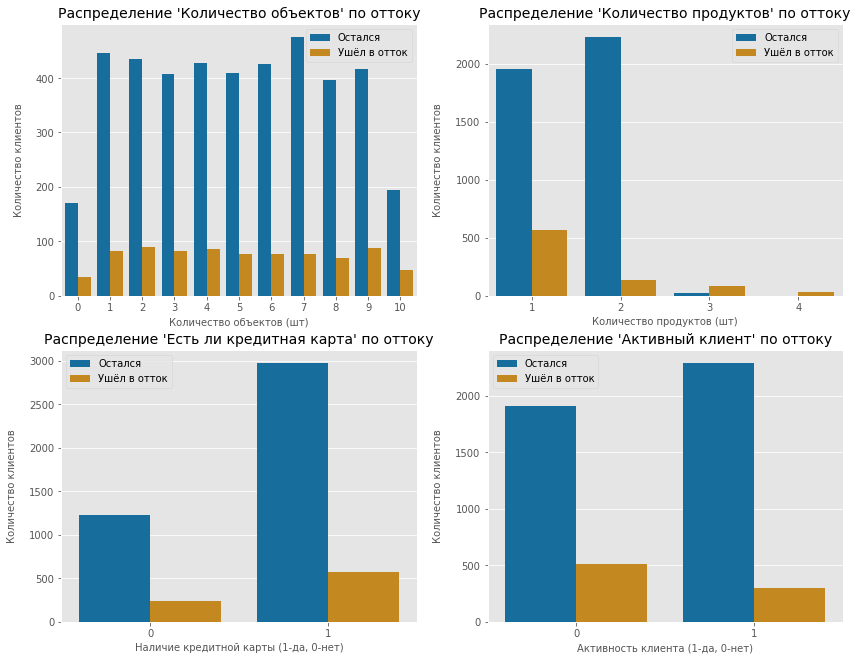

In [29]:
draws2(df_yaroslavl)

In [30]:
df_yaroslavl['churn'].value_counts().reset_index().rename(columns={'index': 'churn', 'churn': 'number'})

churn  number
0  0      4204  
1  1      810

In [31]:
df_yaroslavl.isna().sum()

userid              0   
score               0   
city                0   
gender              0   
age                 0   
objects             0   
balance             2418
products            0   
creditcard          0   
loyalty             0   
estimated_salary    0   
churn               0   
dtype: int64

Подытог по городу Ярославль:
1) Значительную часть пользователей мы теряем в признаке "products". Мы можем заметить, что чем больше у нашего клиента продуктов, тем меньше вероятность, что он уйдёт в отток.\
2) Также, если клиент не проявляет активность, то скорее всего он уйдёт в отток.\
3) Имеется корреляция между наличием кредитной карты и уходом в отток.\
4) Клиент, имеющий < 400 скоринговых баллов, вероято, скоро покинет банк.\
5) Чем старше пользователь, тем выше шанс его потерять, как клиента

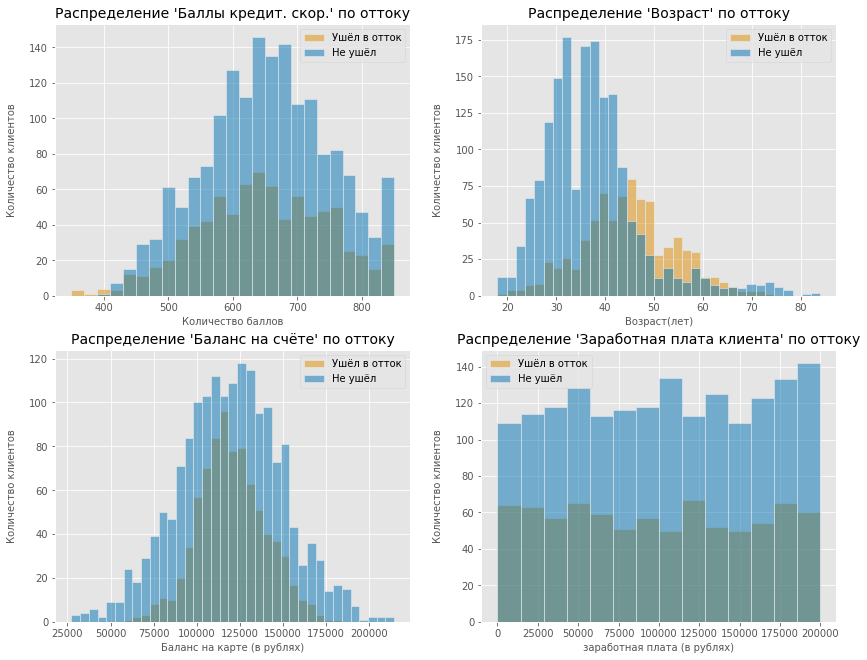

In [32]:
draws1(df_rostov)

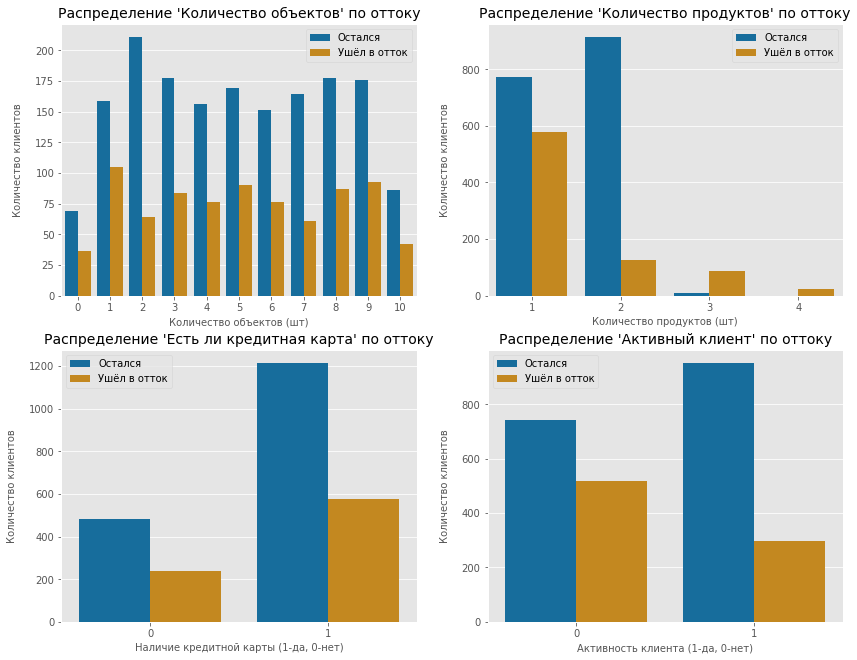

In [33]:
draws2(df_rostov)

In [34]:
df_rostov['churn'].value_counts().reset_index().rename(columns={'index': 'churn', 'churn': 'number'})

churn  number
0  0      1695  
1  1      814

In [35]:
df_rostov.isna().sum()

userid              0
score               0
city                0
gender              0
age                 0
objects             0
balance             0
products            0
creditcard          0
loyalty             0
estimated_salary    0
churn               0
dtype: int64

Подытог к городу Великий Ростов:
1) В городе Великий Ростов очень много людей уходят в отток (примерно 1/3 часть).\
2) Большое количество людей уходят, используя один продукт банка, при этом клиента, которые используя 2, но НЕ более продуктов - более преданы банку.\
3) В основном покидают банк клиенты старше 42 лет.\
4) Заметим, что пропусков в Ростове не обнаружилось.


#### Выведим общую картинку по всем городам:

In [36]:
df.groupby('products')[['age', 'churn']].mean().reset_index()

products    age  churn
0  1        39.673 0.277 
1  2        37.754 0.076 
2  3        43.195 0.827 
3  4        45.683 1.000

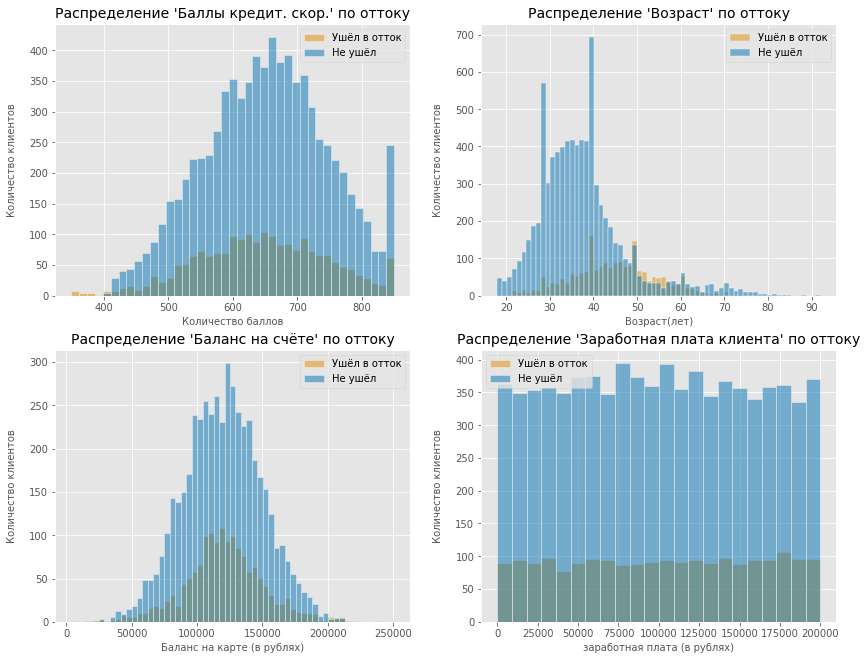

In [37]:
draws1(df)

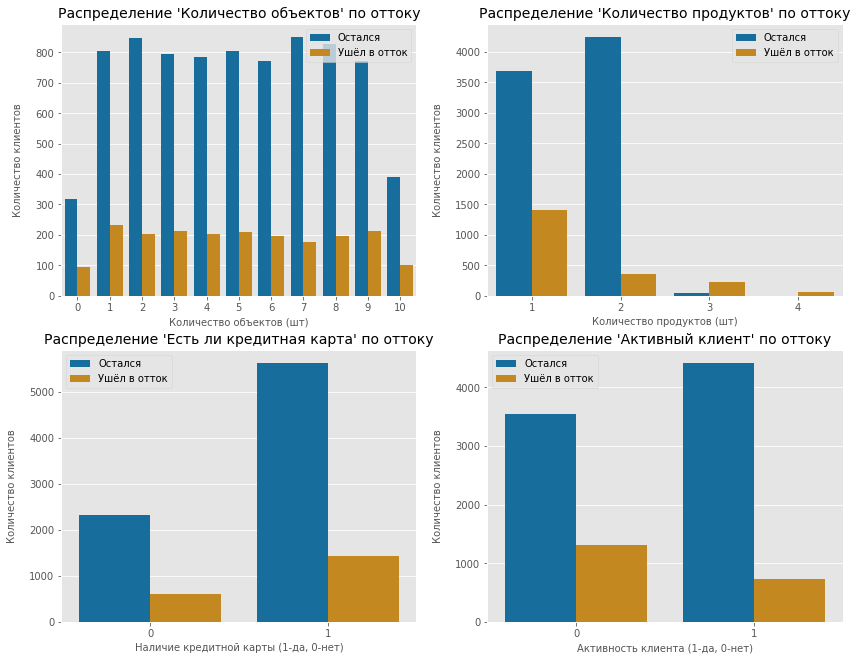

In [38]:
draws2(df)

In [39]:
# Посмотрим на средний возраст и уход в отток клиентов по количеству продуктов в городе Рыбинск
df_ribinsk.groupby('products')[['age', 'churn']].mean().reset_index()

products    age  churn
0  1        39.704 0.219 
1  2        37.902 0.074 
2  3        40.909 0.788 
3  4        45.143 1.000

In [40]:
# Посмотрим на средний возраст и уход в отток клиентов по количеству продуктов в городе Ростов Великий
df_rostov.groupby('products')[['age', 'churn']].mean().reset_index()

products    age  churn
0  1        40.572 0.428 
1  2        38.267 0.121 
2  3        43.656 0.896 
3  4        44.417 1.000

In [41]:
# Посмотрим на средний возраст и уход в отток клиентов по количеству продуктов в городе Ярославль
df_yaroslavl.groupby('products')[['age', 'churn']].mean().reset_index()

products    age  churn
0  1        39.175 0.224 
1  2        37.454 0.057 
2  3        44.221 0.788 
3  4        46.862 1.000

In [50]:
df.groupby('products')[['age', 'churn']].mean().reset_index()

products    age  churn
0  1        39.673 0.277 
1  2        37.754 0.076 
2  3        43.195 0.827 
3  4        45.683 1.000

Клиенты с большой вероятностью уйдут в отток, ипользуя 3 и более продуктов банка.\
Пользователи старше 38 лет так же с большей вероятностью покинут банк.

Специфика пропусков:\
Стоит обратить внимание на город Ростов Великий, в нём отсутствуют пропуски, поскольку пользователи банка 100% имеют дебетовую карту, что не скажешь о городах Ярославль и Рыбинск, там вероятно, люди пользуются дргуими продуктами банка.

<a id="hypothesis"></a> 

# 4 Шаг: Сформулируем и проверим статистические гипотезы.

## 1.Проверим гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.

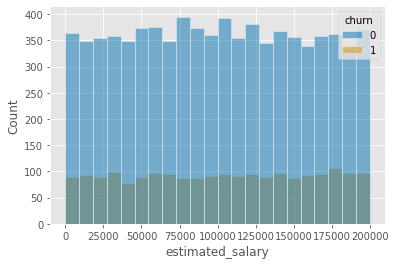

In [43]:
# Посмотрим распределние зарплат в зависимости от churn
sns.histplot(data=df, x='estimated_salary', hue='churn', palette='colorblind')

Распределение зарплат распределено не нормально, ближе к равномерному распределению, поэтому будем использовать непараметрический критерий Манна-Уитни

#### Различается ли доход между теми клиентами, которые ушли и теми, которые остались?

#### Формулировка нулевой и альтернативной гипотез:

H0: Доход между клиентами, которые ушли и теми, которые остались не отличается

H1: Доход между клиентами, которые ушли и теми, которые остались различается

In [44]:
alpha = .05 # критический уровень статистической значимости

In [45]:
mw_av_receipt_test_with_outliers = stats.mannwhitneyu(df[df['churn']== 1]['estimated_salary'],
                                                      df[df['churn']== 0]['estimated_salary'], alternative = 'two-sided')

print('p-value: {0:.3f}'.format(mw_av_receipt_test_with_outliers.pvalue))

if mw_av_receipt_test_with_outliers.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

# относительная разница в средних поступлениях
diff_in_av_receipts = (df[df['churn']== 1]
    ['estimated_salary'].mean() / df[df['churn']== 0]['estimated_salary'].mean()- 1)

print('Средняя зарплата в группе "Клиент ушёл в отток" составляет {0:.2%} выше, чем в группе "Клиент остался"'.format(diff_in_av_receipts))

p-value: 0.227
Не удалось отвергнуть нулевую гипотезу
Средняя зарплата в группе "Клиент ушёл в отток" составляет 1.73% выше, чем в группе "Клиент остался"


Основываясь на непараметрический критерий Манна-Уитни, доход между клиентами, которые ушли и теми, которые остались не отличается

## 2.Проверим гипотезу различия среднего возраста людей, которые активны и не активны 

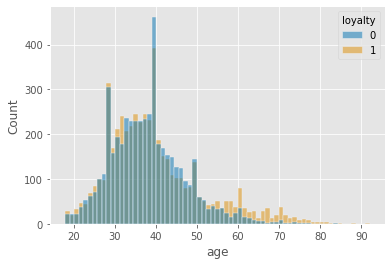

In [46]:
# Посмотрим распределние зарплат в зависимости от loyalty
sns.histplot(data=df, x='age', hue='loyalty', palette='colorblind')

Этот график похож на биномиальное распределение, поэтому можем применить непараметрический критерий Манна-Уитни

#### Различается ли средний возраст клиентов, которые активны и не активны?

#### Формулировка нулевой и альтернативной гипотез:

H0: Средний возраст клиентов, которые активны и не активны не отличается

H1: Средний возраст клиентов, которые активны и не активны различается

In [47]:
alpha = .05 # критический уровень статистической значимости

In [48]:
mw_av_receipt_test_with_outliers = stats.mannwhitneyu(df[df['loyalty']== 1]['age'],
                                                      df[df['loyalty']== 0]['age'], alternative = 'two-sided')

print('p-value: {0:.3f}'.format(mw_av_receipt_test_with_outliers.pvalue))

if mw_av_receipt_test_with_outliers.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

# относительная разница в средних поступлениях
diff_in_av_receipts = (df[df['loyalty']== 1]
    ['age'].mean() / df[df['loyalty']== 0]['age'].mean()- 1)

print('Средняя зарплата в группе "Клиент ушёл в отток" составляет {0:.2%} выше, чем в группе "Клиент остался"'.format(diff_in_av_receipts))

p-value: 0.000
Отвергаем нулевую гипотезу
Средняя зарплата в группе "Клиент ушёл в отток" составляет 4.72% выше, чем в группе "Клиент остался"


Средний возраст клиентов, которые активны и не активны различается статистически значимо.

<a id="recomendations"></a> 

# 5 Шаг: Общий вывод:

Я провел исследовательский анализ данных и сделал следующий вывод.\
\
Портрет людей, которые склонны уходить:
1) Клиент, который имеет 3 и более продукта с вероятносью 99% уйдут в отток. Но также стоит обратить внимание на пользователей, которые прользуются одним продуктом, так как у этих людей немалый относительный процент оттока.\
2) Пользователи, имеющие  <400 скоринговых баллов, вероято, скоро покинут банк.\
3) Сильно коррелируют признаки отток клиентов от среднего возраста. Мы можем заметить, что чем старше пользователсь банка (>37 лет), тем выше шанс его ухода в отток.\
4) Клиенты, которые НЕ имеют кредитную карту склонны больше уходит от банка, чем те, которые её имеют.\
5) Также стоит отдельно обратить внимание на город Ростов Великий. Там большой относительный процент людей уходят имея на балансе 100-125к рублей. Это скрее всего связано с отсутствием пропусков в признаки "balance", соответственно, 100% людей имеют дебетовую/кредитную карту, что не скажешь про города Рыбинск и Ярославль. Помимо этого, в Ростове Великом много клиентов, которые используют всего 1 продукт банка.


Основываясь на непараметрический критерий Манна-Уитни, доход между клиентами, которые ушли и теми, которые остались не отличается

Средний возраст клиентов, которые активны и не активны различается статистически значимо.

## Стратегия:
Предполагаемые меры для снижения оттока:
- Начать предлагать людям кредитную карту банка, соответственно, усовершенствовать условия пользования кредитной картой, дабы наш уважаемый клиент сам бы хотел этот продукт.
- Клиентам, которые пользуются одним продуктам, предалагать любой другой продукт, чтобы сниизить вероятность ухода в отток.
- Мы заметили, что аудитория 45+ лет активно начинает уходить в отток, поэтому для этой аудитории можно предложить, например, зарплатную карту или что-нибудь подобное.

Презентация: https://disk.yandex.ru/i/phxXPT2t-ORfNw

Дашборд: https://public.tableau.com/app/profile/artem6553/viz/_16396769310330/sheet1?publish=yes